In [1]:
# !pip install --no-cache-dir jupyter-black
# !pip install --no-cache-dir 'numpy<2'
# !pip install --no-cache-dir fiona==1.9.6
# !pip install --no-cache-dir python-box

  Obtaining dependency information for jupyter-black from https://files.pythonhosted.org/packages/bc/48/0b90a8d75f0baf494cacd0c23d4007639faf5089293744755dbbf5154ded/jupyter_black-0.4.0-py3-none-any.whl.metadata
  Obtaining dependency information for black[jupyter]>=21 from https://files.pythonhosted.org/packages/24/c1/ae36fa59a59f9363017ed397750a0cd79a470490860bc7713967d89cdd31/black-25.1.0-cp39-cp39-macosx_11_0_arm64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 1.6 MB/s eta 0:00:00a 0:00:01
  Obtaining dependency information for mypy-extensions>=0.4.3 from https://files.pythonhosted.org/packages/2a/e2/5d3f6ada4297caebe1a2add3b126fe800c96f56dbe5d1988a2cbe0b267aa/mypy_extensions-1.0.0-py3-none-any.whl.metadata
  Obtaining dependency information for pathspec>=0.9.0 from https://files.pythonhosted.org/packages/cc/20/ff623b09d963f88bfde16306a54e12ee5ea43e9b597108672ff3a408aad6/pathspec-0.12.1-py3-none-any.whl.metadata
  Obtaining dependency information for tokeni

In [1]:
%load_ext jupyter_black

In [2]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import geopandas as gpd
import xarray as xr

import shapely
from shapely.geometry import MultiPolygon, Polygon
import stackstac
import pystac_client

from shapely import wkt
from rasterio.enums import Resampling
from dataclasses import dataclass

STAC_API = "https://earth-search.aws.element84.com/v1"
COLLECTION = "sentinel-2-l2a"

/Users/yarem/Quantum/deforestation/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [3]:
@dataclass(frozen=True)
class SCL:
    NO_DATA: int = 0
    SATURATED_OR_DEFECTIVE: int = 1
    DARK_AREA_PIXELS: int = 2
    CLOUD_SHADOWS: int = 3
    VEGETATION: int = 4
    NOT_VEGETATED: int = 5
    WATER: int = 6
    UNCLASSIFIED: int = 7
    CLOUD_MEDIUM_PROBABILITY: int = 8
    CLOUD_HIGH_PROBABILITY: int = 9
    THIN_CIRRUS: int = 10
    SNOW: int = 11

In [97]:
def stac_items_search(
    bbox_wgs, start_date, end_date, max_items=512, cloud_cover_cover_max=70
):
    # Search the catalogue
    catalog = pystac_client.Client.open(STAC_API)
    search = catalog.search(
        collections=[COLLECTION],
        datetime=f"{start_date}/{end_date}",
        bbox=bbox_wgs,
        max_items=max_items,
        query={"eo:cloud_cover": {"lt": cloud_cover_cover_max}},
        fields=[
            "id",
            "type",
            "geometry",
            "properties.eo:cloud_cover",
            "properties.proj:epsg",
            "properties.proj:transform",
        ],
    )

    all_items = search.get_all_items()

    # Reduce to one per date (there might be some duplicates
    # based on the location)
    items = []
    dates = []
    for item in all_items:
        if item.datetime.date() not in dates:
            items.append(item)
            dates.append(item.datetime.date())

    return items


def stac_items_compute(items, bbox, bands):
    gsd = 10  # [m/px]
    if len(items) == 0:
        return "no items"
    epsg = items[0].properties["proj:epsg"]

    # Retrieve the pixel values, for the bounding box in
    # the target projection. In this example we use only
    # the RGB and NIR bands.
    stack = stackstac.stack(
        items,
        bounds=bbox,
        snap_bounds=False,
        epsg=epsg,
        resolution=gsd,
        dtype="float32",
        rescale=False,
        fill_value=np.float32(0),
        assets=bands,
        resampling=Resampling.nearest,
    )
    return stack


def get_bbox(gdf, buffer_m=10):
    gdf_buf = gdf.to_crs(gdf.estimate_utm_crs())
    gdf_buf["geometry"] = gdf_buf["geometry"].buffer(buffer_m)
    gdf_buf = gdf_buf.to_crs("EPSG:4326")
    lon, lat = gdf_buf["geometry"].iloc[0].centroid.xy

    bbox = gdf_buf.to_crs(gdf_buf.estimate_utm_crs())["geometry"].iloc[0].bounds
    bbox_wgs = gdf_buf["geometry"].iloc[0].bounds
    lat = lat[0]
    lon = lon[0]
    return lon, lat, bbox, bbox_wgs, max(bbox[2] - bbox[0], bbox[3] - bbox[1])


def prepare_datacube(
    sample: dict,
    max_items: int = 2048,
    cloud_cover_cover_max: float = 70,
    buffer_m: float = 0,
) -> dict:
    bands = [
        "blue",
        "green",
        "red",
        "nir",
        "nir08",
        "swir16",
        "scl",
    ]
    grove_geom = gpd.GeoDataFrame(
        [
            {
                "geometry": (
                    wkt.loads(sample["geometry"])
                    if isinstance(sample["geometry"], str)
                    else sample["geometry"]
                )
            }
        ],
        crs="EPSG:4326",
        geometry="geometry",
    )
    lon, lat, bbox, bbox_wgs, largest_side = get_bbox(grove_geom, buffer_m=buffer_m)

    end_date = sample["end_date"]
    start_date = sample["start_date"]
    items = stac_items_search(
        bbox_wgs,
        start_date,
        end_date,
        max_items=max_items,
        cloud_cover_cover_max=cloud_cover_cover_max,
    )
    stack = stac_items_compute(items, bbox, bands)
    return stack


def add_band_to_dataarray(data, new_band, band_name):
    """
    Adds a new band to an existing xarray.DataArray.

    Parameters:
    - data (xr.DataArray): Original DataArray with shape (time, bands, x, y).
    - new_band (xr.DataArray): New DataArray with shape (time, x, y).
    - band_name (str): Name of the new band to add.

    Returns:
    - xr.DataArray: Updated DataArray with the new band added.
    """
    # Check dimensions of the input DataArray
    if "band" not in data.dims:
        raise ValueError("Input DataArray must have a 'band' dimension.")

    if set(new_band.dims) != {"time", "x", "y"}:
        raise ValueError("New band must have dimensions ('time', 'x', 'y').")

    new_band = new_band.assign_coords(
        title=None,
        common_name=band_name,
        center_wavelength=None,
        full_width_half_max=None,
    )
    if "gsd" not in new_band.coords:
        new_band = new_band.assign_coords(gsd=10)

    if "raster:bands" in data.coords and "raster:bands" not in new_band.coords:
        new_band = new_band.assign_coords({"raster:bands": None})

    # Expand the new_band along the 'band' dimension
    new_band_expanded = new_band.expand_dims(dim={"band": [band_name]}, axis=1)

    # Concatenate along the 'band' dimension
    updated_data = xr.concat([data, new_band_expanded], dim="band")

    return updated_data


def rename_bands(data, band_mapping):
    """
    Rename bands in an xarray.DataArray based on a provided mapping.

    Parameters:
    - data (xr.DataArray): Input DataArray with a 'band' dimension.
    - band_mapping (dict): Dictionary mapping old band names to new band names.

    Returns:
    - xr.DataArray: DataArray with renamed bands.
    """
    # Ensure the 'band' dimension exists in the DataArray
    if "band" not in data.dims:
        raise ValueError("'band' dimension not found in the DataArray.")

    # Check that the band names to rename exist in the DataArray
    missing_bands = [
        band for band in band_mapping.keys() if band not in data.coords["band"].values
    ]
    if missing_bands:
        raise ValueError(
            f"The following bands are not in the DataArray: {missing_bands}"
        )

    # Rename the bands using the mapping
    new_band_coords = [
        band_mapping[band] if band in band_mapping else band
        for band in data.coords["band"].values
    ]
    data = data.assign_coords(band=new_band_coords)
    return data


def compute_bands(stack):
    red = stack.sel(band="red")
    nir = stack.sel(band="nir")
    green = stack.sel(band="green")
    # swir16 = stack.sel(band="swir16")
    blue = stack.sel(band="blue")
    scl = stack.sel(band="scl")
    # L = 0.5

    stack = add_band_to_dataarray(stack, (nir - red) / (nir + red), "ndvi")
    # stack = add_band_to_dataarray(stack, (nir - swir16) / (nir + swir16), "ndwi")
    stack = add_band_to_dataarray(
        stack, 2.5 * (nir - red) / (nir + 6 * red - 7.5 * blue + 1), "evi"
    )
    # stack = add_band_to_dataarray(stack, (nir - green) / (nir + green), "gndvi")
    # stack = add_band_to_dataarray(
    #     stack, ((nir - red) * (1 + L)) / (nir + red + L), "savi"
    # )
    stack = add_band_to_dataarray(
        stack,
        (
            (scl != SCL.CLOUD_MEDIUM_PROBABILITY)
            & (scl != SCL.CLOUD_HIGH_PROBABILITY)
            & (scl != SCL.THIN_CIRRUS)
            & (scl != SCL.CLOUD_SHADOWS)
        ),
        "scl_cls",
    )
    stack = add_band_to_dataarray(
        stack,
        (scl == SCL.VEGETATION),
        "veg_frac",
    )
    stack = add_band_to_dataarray(
        stack,
        (scl == SCL.NOT_VEGETATED),
        "notveg_frac",
    )
    # stack = stack.sel(band=stack.band != "scl")
    stat_band_names = list(stack.band.values)
    return stack, stat_band_names

# Process correctly

crs=epsg:4326


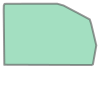

In [5]:
gdf = gpd.read_file("../data/36UXA_time-dependent.geojson")
# gdf = gpd.read_file("../data/36UYA_36UXA_baseline.geojson")
crs = gdf.crs
print(f"crs={crs}")
assert crs == "epsg:4326"
# gdf.to_crs("epsg:6386", inplace=True)

geometry = shapely.ops.unary_union(gdf["geometry"].to_list()).convex_hull
geometry

In [6]:
gdf.head()

,id,TileDate,img_date,geometry
0,None,2017-08-25T00:00:00,2017-08-25,"MULTIPOLYGON (((35.77112 49.61609, 35.77113 49..."
1,None,2017-09-09T00:00:00,2017-09-09,"MULTIPOLYGON (((35.77112 49.61609, 35.77077 49..."
2,None,2017-09-09T00:00:00,2017-09-09,"MULTIPOLYGON (((35.77816 49.61804, 35.77816 49..."
3,None,2017-09-09T00:00:00,2017-09-09,"MULTIPOLYGON (((35.77682 49.61882, 35.77698 49..."
4,None,2017-09-14T00:00:00,2017-09-14,"MULTIPOLYGON (((35.77629 49.61888, 35.77652 49..."


In [9]:
# duplicates = (
#     gdf.groupby("img_date")["tileID"]
#     .nunique()  # Count unique tileID values per img_date
#     .gt(1)  # Check if more than 1 unique value exists
# )
#
# # Extract img_dates with different tileID values
# dates_with_mixed_tileID = duplicates[duplicates].index.tolist()
#
# print(dates_with_mixed_tileID)

In [10]:
# gdf["tileID"].unique()

In [11]:
import geopandas as gpd
from shapely.geometry import MultiPolygon

# Ensure img_date is in datetime format
gdf["img_date"] = pd.to_datetime(gdf["img_date"])

# # Compute convex hull for each img_date and tileID combination
# gdf_hull = (
#     gdf.groupby(["img_date", "tileID"])["geometry"]  # Group by img_date & tileID
#     .agg(lambda geom: MultiPolygon(geom.tolist()).convex_hull)  # Compute convex hull
#     .reset_index()  # Convert back to DataFrame
# )


def flatten_geometries(geometries):
    """Flatten geometries by extracting individual Polygons from MultiPolygons."""
    flat_polygons = []
    for geom in geometries:
        if isinstance(geom, MultiPolygon):
            flat_polygons.extend(geom.geoms)  # Extract polygons from MultiPolygon
        elif isinstance(geom, Polygon):
            flat_polygons.append(geom)  # Keep single polygons as is
    return flat_polygons


# Compute convex hull for each img_date and tileID combination
gdf_hull = (
    gdf.groupby(["img_date"])["geometry"]
    .agg(lambda geom: MultiPolygon(flatten_geometries(geom.tolist())).convex_hull)
    .reset_index()
)

In [13]:
gdf_hull.head()

,img_date,geometry
0,2017-02-01,"POLYGON ((34.60189 49.89926, 34.60181 49.89926..."
1,2017-02-26,"POLYGON ((34.60311 49.89889, 34.60297 49.89890..."
2,2017-08-25,"POLYGON ((35.77113 49.61584, 35.77079 49.61585..."
3,2017-08-30,"POLYGON ((35.42151 50.02371, 35.42100 50.02432..."
4,2017-09-09,"POLYGON ((35.77179 49.61516, 34.65206 49.74639..."


In [14]:
row = gdf_hull.iloc[-1]
sample = {
    "geometry": row["geometry"],
    "start_date": (row["img_date"] - timedelta(days=20)).strftime("%Y-%m-%d"),
    "end_date": (row["img_date"] + timedelta(days=20)).strftime("%Y-%m-%d"),
}
sample

{'geometry': <shapely.geometry.polygon.Polygon at 0x146431280>,
 'start_date': '2018-08-30',
 'end_date': '2018-10-09'}

In [16]:
stack = prepare_datacube(sample, max_items=1, cloud_cover_cover_max=20, buffer_m=250)
stack

/Users/yarem/Quantum/deforestation/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(


<xarray.DataArray 'stackstac-73f12a366392bdab73d6c19ae3cc855d' (time: 1,
                                                                band: 7,
                                                                y: 9299, x: 8871)> Size: 2GB
dask.array<fetch_raster_window, shape=(1, 7, 9299, 8871), dtype=float32, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/14)
  * time                 (time) datetime64[ns] 8B 2018-10-09T08:38:50.283000
    id                   (time) <U24 96B 'S2A_36UYV_20181009_0_L2A'
  * band                 (band) <U6 168B 'blue' 'green' 'red' ... 'swir16' 'scl'
  * x                    (x) float64 71kB 6.187e+05 6.187e+05 ... 7.074e+05
  * y                    (y) float64 74kB 5.592e+06 5.592e+06 ... 5.499e+06
    proj:epsg            int64 8B 32636
    ...                   ...
    raster:bands         (band) object 56B {'offset': 0, 'data_type': 'uint16...
    title                (band) <U30 840B 'Blue (band 2) - 10m' ... 'Scene cl...
    common_name          (band) object 56B 'blue' 'green' ... 'swir16' None
    center_wavelength    (band) object 56B 0.49 0.56 0.665 0.842 0.865 1.61 None
    full_width_half_max  (band) object 56B 0.098 0.045 0.038 ... 0.143 None
    epsg                 int64 8B 32636
Attributes:
    spec:        RasterSpec(epsg=32636, bounds=(618696.9702606112, 5498888.53...
    crs:         epsg:32636
    transform:   | 10.00, 0.00, 618696.97|\n| 0.00,-10.00, 5591873.61|\n| 0.0...
    resolution:  10

In [19]:
stack.shape[2]

9299

In [20]:
samples = [
    {
        "geometry": row["geometry"],
        "start_date": (row["img_date"] - timedelta(days=5)).strftime("%Y-%m-%d"),
        "end_date": (row["img_date"] + timedelta(days=5)).strftime("%Y-%m-%d"),
    }
    for _, row in gdf_hull.iterrows()
]
samples

[{'geometry': <shapely.geometry.polygon.Polygon at 0x14643ec10>,
  'start_date': '2017-01-27',
  'end_date': '2017-02-06'},
 {'geometry': <shapely.geometry.polygon.Polygon at 0x14643e520>,
  'start_date': '2017-02-21',
  'end_date': '2017-03-03'},
 {'geometry': <shapely.geometry.polygon.Polygon at 0x14643e0a0>,
  'start_date': '2017-08-20',
  'end_date': '2017-08-30'},
 {'geometry': <shapely.geometry.polygon.Polygon at 0x14643e4c0>,
  'start_date': '2017-08-25',
  'end_date': '2017-09-04'},
 {'geometry': <shapely.geometry.polygon.Polygon at 0x14643e100>,
  'start_date': '2017-09-04',
  'end_date': '2017-09-14'},
 {'geometry': <shapely.geometry.polygon.Polygon at 0x14643ed60>,
  'start_date': '2017-09-09',
  'end_date': '2017-09-19'},
 {'geometry': <shapely.geometry.polygon.Polygon at 0x14643e070>,
  'start_date': '2017-09-14',
  'end_date': '2017-09-24'},
 {'geometry': <shapely.geometry.polygon.Polygon at 0x14643e7c0>,
  'start_date': '2017-09-29',
  'end_date': '2017-10-09'},
 {'geome

In [41]:
stacks = [
    prepare_datacube(sample, max_items=1, cloud_cover_cover_max=40, buffer_m=250)
    for sample in samples
]

/Users/yarem/Quantum/deforestation/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
/Users/yarem/Quantum/deforestation/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
/Users/yarem/Quantum/deforestation/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
/Users/yarem/Quantum/deforestation/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
/Users/yarem/Quantum/deforestation/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
/Users/yarem/Qu

In [48]:
stacks = []
for sample in samples:
    stack = prepare_datacube(
        sample, max_items=1, cloud_cover_cover_max=50, buffer_m=250
    )
    if isinstance(stack, str):
        continue
    buffer_h = max(250, 2240 - (stack.shape[2] - 25) * 10)
    buffer_w = max(250, 2240 - (stack.shape[3] - 25) * 10)
    buffer_m = max(buffer_h, buffer_w)
    if buffer_m > 250:
        stack = prepare_datacube(
            sample, max_items=1, cloud_cover_cover_max=50, buffer_m=buffer_m
        )
    stacks.append(stack)

/Users/yarem/Quantum/deforestation/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
/Users/yarem/Quantum/deforestation/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
/Users/yarem/Quantum/deforestation/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
/Users/yarem/Quantum/deforestation/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
/Users/yarem/Quantum/deforestation/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
/Users/yarem/Qu

In [49]:
stacks[21]

<xarray.DataArray 'stackstac-aa09dcc07bbfc928cdafe64705266b8e' (time: 1,
                                                                band: 7,
                                                                y: 11838,
                                                                x: 8033)> Size: 3GB
dask.array<fetch_raster_window, shape=(1, 7, 11838, 8033), dtype=float32, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/14)
  * time                 (time) datetime64[ns] 8B 2018-05-07T08:36:59.789000
    id                   (time) <U24 96B 'S2B_36UXV_20180507_0_L2A'
  * band                 (band) <U6 168B 'blue' 'green' 'red' ... 'swir16' 'scl'
  * x                    (x) float64 64kB 6.007e+05 6.007e+05 ... 6.81e+05
  * y                    (y) float64 95kB 5.605e+06 5.605e+06 ... 5.486e+06
    proj:epsg            int64 8B 32636
    ...                   ...
    raster:bands         (band) object 56B {'offset': 0, 'data_type': 'uint16...
    title                (band) <U30 840B 'Blue (band 2) - 10m' ... 'Scene cl...
    common_name          (band) object 56B 'blue' 'green' ... 'swir16' None
    center_wavelength    (band) object 56B 0.49 0.56 0.665 0.842 0.865 1.61 None
    full_width_half_max  (band) object 56B 0.098 0.045 0.038 ... 0.143 None
    epsg                 int64 8B 32636
Attributes:
    spec:        RasterSpec(epsg=32636, bounds=(600700.3418570447, 5486216.75...
    crs:         epsg:32636
    transform:   | 10.00, 0.00, 600700.34|\n| 0.00,-10.00, 5604595.20|\n| 0.0...
    resolution:  10

In [50]:
len(stacks)

46

In [51]:
stacks = [stack for stack in stacks if isinstance(stack, xr.DataArray)]

In [52]:
len(stacks)

46

In [53]:
min_height = min([stack.shape[2] for stack in stacks])
min_width = min([stack.shape[3] for stack in stacks])
min_height, min_width

(388, 386)

In [54]:
stacks[0].band

<xarray.DataArray 'band' (band: 7)> Size: 168B
array(['blue', 'green', 'red', 'nir', 'nir08', 'swir16', 'scl'], dtype='<U6')
Coordinates:
  * band                 (band) <U6 168B 'blue' 'green' 'red' ... 'swir16' 'scl'
    proj:epsg            int64 8B 32636
    eo:cloud_cover       float64 8B 1.046
    gsd                  (band) object 56B 10 10 10 10 20 20 None
    raster:bands         (band) object 56B {'offset': 0, 'data_type': 'uint16...
    title                (band) <U30 840B 'Blue (band 2) - 10m' ... 'Scene cl...
    common_name          (band) object 56B 'blue' 'green' ... 'swir16' None
    center_wavelength    (band) object 56B 0.49 0.56 0.665 0.842 0.865 1.61 None
    full_width_half_max  (band) object 56B 0.098 0.045 0.038 ... 0.143 None
    epsg                 int64 8B 32636

In [62]:
len(stacks[0].band)

7

In [98]:
stacks_stat_band_names = [
    compute_bands(stack) for stack in stacks if len(stack.band) > 0
]

In [99]:
len(stacks_stat_band_names)

45

In [59]:
stacks[21]

<xarray.DataArray 'stackstac-aa09dcc07bbfc928cdafe64705266b8e' (time: 1,
                                                                band: 7,
                                                                y: 11838,
                                                                x: 8033)> Size: 3GB
dask.array<fetch_raster_window, shape=(1, 7, 11838, 8033), dtype=float32, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/14)
  * time                 (time) datetime64[ns] 8B 2018-05-07T08:36:59.789000
    id                   (time) <U24 96B 'S2B_36UXV_20180507_0_L2A'
  * band                 (band) <U6 168B 'blue' 'green' 'red' ... 'swir16' 'scl'
  * x                    (x) float64 64kB 6.007e+05 6.007e+05 ... 6.81e+05
  * y                    (y) float64 95kB 5.605e+06 5.605e+06 ... 5.486e+06
    proj:epsg            int64 8B 32636
    ...                   ...
    raster:bands         (band) object 56B {'offset': 0, 'data_type': 'uint16...
    title                (band) <U30 840B 'Blue (band 2) - 10m' ... 'Scene cl...
    common_name          (band) object 56B 'blue' 'green' ... 'swir16' None
    center_wavelength    (band) object 56B 0.49 0.56 0.665 0.842 0.865 1.61 None
    full_width_half_max  (band) object 56B 0.098 0.045 0.038 ... 0.143 None
    epsg                 int64 8B 32636
Attributes:
    spec:        RasterSpec(epsg=32636, bounds=(600700.3418570447, 5486216.75...
    crs:         epsg:32636
    transform:   | 10.00, 0.00, 600700.34|\n| 0.00,-10.00, 5604595.20|\n| 0.0...
    resolution:  10

In [62]:
np.sum([stack.nbytes / 1e9 for stack in stacks])

95.88778766

In [106]:
stack, stat_band_names = stacks_stat_band_names[0]
stat_band_names

['blue',
 'green',
 'red',
 'nir',
 'nir08',
 'swir16',
 'scl',
 'ndvi',
 'evi',
 'scl_cls',
 'veg_frac',
 'notveg_frac']

In [107]:
array = stack.values
# T C H W
array.shape

(1, 12, 395, 395)

In [102]:
stack.band

<xarray.DataArray 'band' (band: 12)> Size: 96B
array(['blue', 'green', 'red', 'nir', 'nir08', 'swir16', 'scl', 'ndvi', 'evi',
       'scl_cls', 'veg_frac', 'notveg_frac'], dtype=object)
Coordinates:
  * band                 (band) object 96B 'blue' 'green' ... 'notveg_frac'
    proj:epsg            int64 8B 32636
    eo:cloud_cover       float64 8B 36.36
    gsd                  (band) object 96B 10 10 10 10 20 ... 10 None None None
    raster:bands         (band) object 96B {'offset': 0, 'data_type': 'uint16...
    title                (band) object 96B 'Blue (band 2) - 10m' ... None
    common_name          (band) object 96B 'blue' 'green' ... 'notveg_frac'
    center_wavelength    (band) object 96B 0.49 0.56 0.665 ... None None None
    full_width_half_max  (band) object 96B 0.098 0.045 0.038 ... None None None
    epsg                 int64 8B 32636

In [103]:
import yaml
from box import Box


def read_sentinel2_metainfo(bands: list, metadata_path=""):
    metadata = Box(yaml.safe_load(open("../satconfig.yaml")))
    platform = "sentinel-2-l2a"

    mean = []
    std = []
    waves = []
    # Use the band names to get the correct values in the correct order.
    for band in [b for b in bands if b != "scl"]:
        mean.append(metadata[platform].bands.mean[band])
        std.append(metadata[platform].bands.std[band])
        waves.append(metadata[platform].bands.wavelength[band])
    return mean, std, waves


bands = [
    "blue",
    "green",
    "red",
    "nir",
    "nir08",
    "swir16",
]
mean, std, waves = read_sentinel2_metainfo(bands=bands)
sentinel2_metainfo = pd.DataFrame(
    {"bands": bands, "mean": mean, "std": std, "waves": waves}
)
sentinel2_metainfo

,bands,mean,std,waves
0,blue,1105.0,1809.0,0.493
1,green,1355.0,1757.0,0.560
2,red,1552.0,1888.0,0.665
3,nir,2743.0,1742.0,0.842
4,nir08,2785.0,1648.0,0.865
5,swir16,2388.0,1470.0,1.610


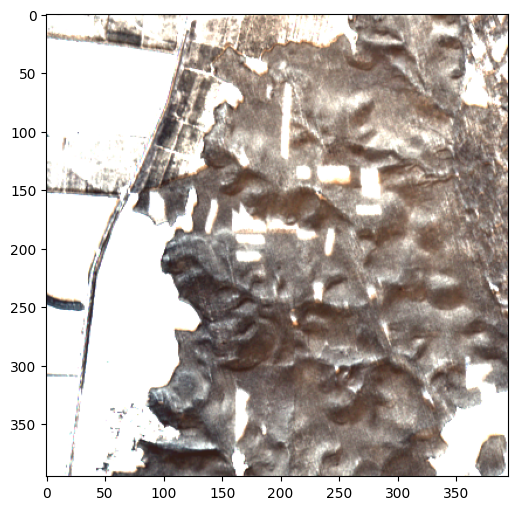

In [108]:
import matplotlib.pyplot as plt

mean = sentinel2_metainfo["mean"].iloc[:3].to_numpy()
std = sentinel2_metainfo["std"].iloc[:3].to_numpy()

scale = lambda x: ((x - mean) / std + 1) / 2

plt.figure(figsize=(6, 6))
plt.imshow(scale(array[0, :3].transpose(1, 2, 0)))
plt.show()

# plt.figure(figsize=(6, 6))
# plt.imshow(scale(array[-4, :3].transpose(1, 2, 0)))
# plt.show()

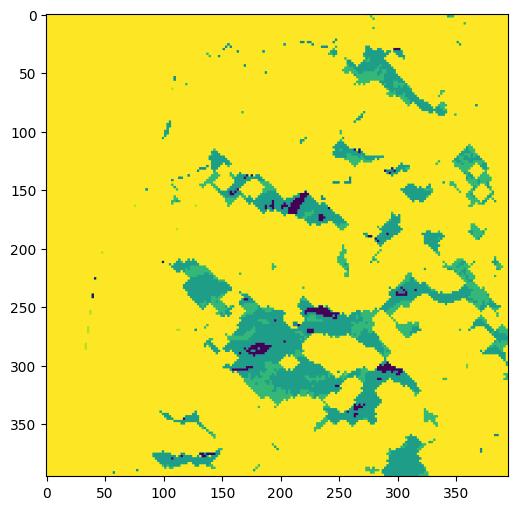

In [109]:
plt.figure(figsize=(6, 6))
plt.imshow(array[0, 6])
plt.show()

In [72]:
for i in range(array.shape[2]):
    if array[0, -1, i, 0] != 0:
        print(i)
        break

10458


In [110]:
found0 = False
for i in range(0, array.shape[2]):
    for j in range(array.shape[3]):
        if array[0, -1, i, j] == 0:
            print(i, j)
            found0 = True
            break
print(f"found0: {found0}")

0 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
17 0
18 0
19 0
20 0
21 0
22 0
23 0
24 0
25 0
26 0
27 0
28 0
29 0
30 0
31 0
32 0
33 0
34 0
35 0
36 0
37 0
38 0
39 0
40 0
41 0
42 0
43 0
44 0
45 0
46 0
47 0
48 0
49 0
50 0
51 0
52 0
53 0
54 0
55 0
56 0
57 0
58 0
59 0
60 0
61 0
62 0
63 0
64 0
65 0
66 0
67 0
68 0
69 0
70 0
71 0
72 0
73 0
74 0
75 0
76 0
77 0
78 0
79 0
80 0
81 0
82 0
83 0
84 0
85 0
86 0
87 0
88 0
89 0
90 0
91 0
92 0
93 0
94 0
95 0
96 0
97 0
98 0
99 0
100 0
101 0
102 0
103 0
104 0
105 0
106 0
107 0
108 0
109 0
110 0
111 0
112 0
113 0
114 0
115 0
116 0
117 0
118 0
119 0
120 0
121 0
122 0
123 0
124 0
125 0
126 0
127 0
128 0
129 0
130 0
131 0
132 0
133 0
134 0
135 0
136 0
137 0
138 0
139 0
140 0
141 0
142 0
143 0
144 0
145 0
146 0
147 0
148 0
149 0
150 0
151 0
152 0
153 0
154 0
155 0
156 0
157 0
158 0
159 0
160 0
161 0
162 0
163 0
164 0
165 0
166 0
167 0
168 0
169 0
170 0
171 0
172 0
173 0
174 0
175 0
176 0
177 0
178 0
179 0
180 0
181 0
182 0
183 0
184 0


In [77]:
len(stacks)

46

In [76]:
for stack in stacks:
    if stack.shape[0] == 0:
        print("Found stack!")

Found stack!


In [ ]:
arrays = [stack.values for stack, _ in stacks_stat_band_names]

In [ ]:
all_pixels = [array.shape[2] * array.shape[3] for array in arrays]
non_zero_pixels = np.count_nonzero([array[0, 6] for array in arrays])
(non_zero_pixels / all_pixels) * 100

# Process all together

crs=epsg:4326


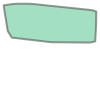

In [37]:
gdf = gpd.read_file("../data/36UYA_36UXA_baseline.geojson")
# gdf = gdf[["geometry"]]
crs = gdf.crs
print(f"crs={crs}")
assert crs == "epsg:4326"
# gdf.to_crs("epsg:6386", inplace=True)

geometry = shapely.ops.unary_union(gdf["geometry"].to_list()).convex_hull
geometry

In [38]:
gdf.head()

,tileID,img_date,geometry
0,20180830T084029_36UXA,2018-08-30,"POLYGON Z ((35.04533 50.45621 0.00000, 35.0452..."
1,20180830T084029_36UXA,2018-08-30,"POLYGON Z ((34.76123 50.44090 0.00000, 34.7600..."
2,20180830T084029_36UXA,2018-08-30,"POLYGON Z ((34.85014 50.45595 0.00000, 34.8501..."
3,20180830T084029_36UXA,2018-08-30,"POLYGON Z ((34.74267 50.46371 0.00000, 34.7426..."
4,20180830T084029_36UXA,2018-08-30,"POLYGON Z ((34.74311 50.46287 0.00000, 34.7432..."


In [88]:
gdf_hull = (
    gdf.groupby("img_date")["geometry"]  # Group by 'img_date'
    .agg(
        lambda geom: MultiPolygon(geom.tolist()).convex_hull
    )  # Convert to MultiPolygon & compute convex hull
    .reset_index()  # Reset index to make it a DataFrame
)

# # Convert to a GeoDataFrame
# gdf_hull = gpd.GeoDataFrame(gdf_hull, geometry="geometry", crs=gdf.crs)

/Users/yarem/Quantum/deforestation/.venv/lib/python3.9/site-packages/shapely/geometry/multipolygon.py:202: ShapelyDeprecationWarning: __getitem__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  shell = ob[0]
/Users/yarem/Quantum/deforestation/.venv/lib/python3.9/site-packages/shapely/geometry/multipolygon.py:203: ShapelyDeprecationWarning: __getitem__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  holes = ob[1]


In [95]:
gdf_hull["img_date"] = pd.to_datetime(gdf_hull["img_date"])
gdf_hull.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 39 entries, 0 to 38
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   img_date  39 non-null     datetime64[ns]
 1   geometry  39 non-null     geometry      
dtypes: datetime64[ns](1), geometry(1)
memory usage: 752.0 bytes


In [98]:
len(gdf_hull), len(gdf_hull[gdf_hull["img_date"] >= "2017-01-01"])

(39, 21)

In [99]:
gdf_hull[gdf_hull["img_date"] >= "2017-01-01"].head()

,img_date,geometry
18,2018-08-30,"POLYGON Z ((202401.910 5504921.419 0.000, 2023..."
19,2018-09-19,"POLYGON Z ((255883.168 5498827.416 0.000, 2025..."
20,2019-02-12,"POLYGON ((328033.620 5552261.637, 327982.435 5..."
21,2019-03-03,"POLYGON Z ((286626.993 5493634.188 0.000, 2030..."
22,2019-04-27,"POLYGON Z ((285931.313 5494078.162 0.000, 2032..."


In [104]:
gdf_hull[gdf_hull["img_date"] >= "2017-01-01"]["geometry"].area.mean()

2488726325.608692

In [76]:
len(gdf)

2318

In [86]:
gdf["geometry"].area.median()

18742.121419540705

In [75]:
gdf.head()

,geometry
0,"POLYGON Z ((232316.569 5592132.781 0.000, 2323..."
1,"POLYGON Z ((212113.239 5590727.436 0.000, 2120..."
2,"POLYGON Z ((218455.363 5592300.406 0.000, 2184..."
3,"POLYGON Z ((210837.697 5593286.813 0.000, 2108..."
4,"POLYGON Z ((210867.876 5593192.530 0.000, 2108..."


In [39]:
import geojson

# with open("../data/36UYA_36UXA_baseline.geojson", "r") as geojson_file:
#     geometry_json = geojson.load(geojson_file)

with open("../data/36UYA_36UXA_baseline.geojson", "r") as geojson_file:
    geometry_json = geojson.load(geojson_file)

geometry_json["features"][0]["properties"]

{'tileID': '20180830T084029_36UXA', 'img_date': '2018-08-30'}

In [32]:
type(geometry_json)

geojson.feature.FeatureCollection

In [14]:
import json


# Assuming geometry_json is already loaded as a dictionary
def filter_geojson_by_date(geometry_json, target_date):
    """Filter features by img_date and save as a new GeoJSON file."""
    filtered_features = [
        feature
        for feature in geometry_json["features"]
        if feature["properties"].get("img_date") == target_date
    ]

    # Create new FeatureCollection with filtered features
    geom_filtered = {"type": "FeatureCollection", "features": filtered_features}

    return geom_filtered


# Call function
filtered_geojson = filter_geojson_by_date(geometry_json, "2017-02-01")

In [18]:
filtered_geojson["features"][0]["properties"]

{'id': None, 'TileDate': '2017/02/01 00:00:00', 'img_date': '2017-02-01'}

In [15]:
filtered_geojson

{'type': 'FeatureCollection',
 'features': [{"geometry": {"coordinates": [[[[34.601815, 49.899558], [34.601989, 49.899558], [34.602093, 49.899539], [34.602123, 49.899495], [34.602146, 49.899435], [34.602146, 49.899391], [34.602139, 49.899345], [34.602123, 49.899298], [34.602074, 49.899275], [34.602008, 49.899266], [34.601956, 49.899258], [34.60189, 49.899258], [34.601811, 49.899264], [34.601723, 49.899288], [34.601713, 49.899334], [34.601733, 49.899488], [34.601815, 49.899558]]]], "type": "MultiPolygon"}, "properties": {"TileDate": "2017/02/01 00:00:00", "id": null, "img_date": "2017-02-01"}, "type": "Feature"}]}

In [19]:
# Save filtered GeoJSON
with open("filtered_geojson.geojson", "w") as f:
    json.dump(filtered_geojson, f, indent=4)

In [33]:
dates = set(
    [
        geometry_json["features"][i]["properties"]["img_date"]
        for i in range(len(geometry_json["features"]))
    ]
)
dates = sorted(dates)

In [34]:
dates

['2016-01-03',
 '2016-01-30',
 '2016-02-12',
 '2016-03-30',
 '2016-04-09',
 '2016-04-12',
 '2016-05-02',
 '2016-05-09',
 '2016-05-22',
 '2016-06-18',
 '2016-06-21',
 '2016-07-31',
 '2016-08-20',
 '2016-08-30',
 '2016-10-02',
 '2016-10-26',
 '2016-11-21',
 '2016-12-05',
 '2018-08-30',
 '2018-09-19',
 '2019-02-12',
 '2019-03-03',
 '2019-04-27',
 '2019-05-22',
 '2019-06-06',
 '2019-07-01',
 '2019-07-06',
 '2019-07-21',
 '2019-07-26',
 '2019-07-31',
 '2019-08-05',
 '2019-08-10',
 '2019-08-15',
 '2019-08-20',
 '2019-08-25',
 '2019-08-30',
 '2019-09-04',
 '2019-09-09',
 '2019-10-26']

In [35]:
dates[0], dates[-1]

('2016-01-03', '2019-10-26')

In [41]:
# geometries = dict()
# for img_date in set(json_gdf["img_date"]):
#     geometries[img_date] = shapely.ops.unary_union(
#         json_gdf[json_gdf["img_date"] == img_date]["geometry"].to_list()
#     ).convex_hull
single_geometry = shapely.geometry.MultiPolygon(
    filtered_geojson["features"][0]["geometry"]["coordinates"][0]
)

AttributeError: 'list' object has no attribute '_ndim'

In [55]:
filtered_geojson

{'type': 'FeatureCollection',
 'features': [{"geometry": {"coordinates": [[[[34.601815, 49.899558], [34.601989, 49.899558], [34.602093, 49.899539], [34.602123, 49.899495], [34.602146, 49.899435], [34.602146, 49.899391], [34.602139, 49.899345], [34.602123, 49.899298], [34.602074, 49.899275], [34.602008, 49.899266], [34.601956, 49.899258], [34.60189, 49.899258], [34.601811, 49.899264], [34.601723, 49.899288], [34.601713, 49.899334], [34.601733, 49.899488], [34.601815, 49.899558]]]], "type": "MultiPolygon"}, "properties": {"TileDate": "2017/02/01 00:00:00", "id": null, "img_date": "2017-02-01"}, "type": "Feature"}]}

In [80]:
filtered_gdf = gpd.read_file("filtered_geojson.geojson")
filtered_gdf.head()

,id,TileDate,img_date,geometry
0,None,2017-02-01T00:00:00,2017-02-01,"MULTIPOLYGON (((34.60182 49.89956, 34.60199 49..."


In [82]:
filtered_gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [83]:
filtered_gdf.to_crs("epsg:6386", inplace=True)

In [84]:
filtered_gdf["geometry"].area

0    904.558497
dtype: float64

In [63]:
len(filtered_geojson["features"][0]["geometry"]["coordinates"][0][0])

17

In [66]:
# Extracting the coordinates correctly
multi_polygon_coords = filtered_geojson["features"][0]["geometry"]["coordinates"]

# Convert each polygon into a Shapely Polygon
polygons = [Polygon(coords[0]) for coords in multi_polygon_coords]

# Create the MultiPolygon
multi_polygon = MultiPolygon(polygons)

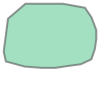

In [67]:
multi_polygon

In [68]:
single_geometry = multi_polygon.convex_hull

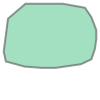

In [69]:
single_geometry

In [40]:
sample = {
    "geometry": geometry,
    "start_date": dates[0],
    "end_date": dates[-1],
}
stack = prepare_datacube(sample, max_items=1024, cloud_cover_cover_max=20, buffer_m=0)

collection: sentinel-2-l2a


/Users/yarem/Quantum/deforestation/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(


1024


In [41]:
stack

<xarray.DataArray 'stackstac-3029ed1b348aba11f43ce163bc5406a8' (time: 111,
                                                                band: 7,
                                                                y: 11689,
                                                                x: 18543)> Size: 674GB
dask.array<fetch_raster_window, shape=(111, 7, 11689, 18543), dtype=float32, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/14)
  * time                 (time) datetime64[ns] 888B 2018-10-07T08:56:30.40600...
    id                   (time) <U24 11kB 'S2B_36UWV_20181007_1_L2A' ... 'S2A...
  * band                 (band) <U6 168B 'blue' 'green' 'red' ... 'swir16' 'scl'
  * x                    (x) float64 148kB 6.009e+05 6.009e+05 ... 7.863e+05
  * y                    (y) float64 94kB 5.598e+06 5.598e+06 ... 5.481e+06
    proj:epsg            (time) int64 888B 32636 32637 32637 ... 32636 32636
    ...                   ...
    title                (band) <U30 840B 'Blue (band 2) - 10m' ... 'Scene cl...
    raster:bands         (band) object 56B None ... [{'data_type': 'uint8', '...
    common_name          (band) object 56B 'blue' 'green' ... 'swir16' None
    center_wavelength    (band) object 56B 0.49 0.56 0.665 0.842 0.865 1.61 None
    full_width_half_max  (band) object 56B 0.098 0.045 0.038 ... 0.143 None
    epsg                 int64 8B 32636
Attributes:
    spec:        RasterSpec(epsg=32636, bounds=(600892.5962655663, 5480946.93...
    crs:         epsg:32636
    transform:   | 10.00, 0.00, 600892.60|\n| 0.00,-10.00, 5597834.73|\n| 0.0...
    resolution:  10

In [42]:
stack.time

<xarray.DataArray 'time' (time: 111)> Size: 888B
array(['2018-10-07T08:56:30.406000000', '2018-10-09T08:38:50.283000000',
       '2018-10-11T08:35:43.356000000', '2018-10-12T08:49:03.458000000',
       '2018-10-14T08:39:13.461000000', '2018-10-16T08:31:32.338000000',
       '2018-10-17T08:55:46.451000000', '2018-10-19T08:46:34.033000000',
       '2018-10-22T08:50:40.321000000', '2018-11-01T08:52:25.224000000',
       '2018-11-05T08:33:33.341000000', '2018-11-06T08:56:32.358000000',
       '2018-11-08T08:46:32.596000000', '2018-11-18T08:46:30.896000000',
       '2018-11-23T08:46:30.779000000', '2018-11-28T08:46:28.590000000',
       '2018-11-30T08:36:14.272000000', '2018-12-03T08:45:56.934000000',
       '2018-12-31T08:56:28.546000000', '2019-01-07T08:45:56.730000000',
       '2019-01-15T08:56:34.185000000', '2019-01-17T08:46:33.340000000',
       '2019-01-20T08:56:05.240000000', '2019-01-22T08:46:37.216000000',
       '2019-01-25T08:56:30.564000000', '2019-01-29T08:36:18.856000000',
       '2019-02-14T08:56:08.727000000', '2019-02-18T08:36:18.190000000',
       '2019-02-19T08:56:30.954000000', '2019-02-23T08:36:34.677000000',
       '2019-02-24T09:09:18.883000000', '2019-03-03T08:57:56.098000000',
       '2019-03-06T09:12:17.188000000', '2019-03-13T09:01:46.299000000',
       '2019-03-18T09:01:05.236000000', '2019-03-25T08:43:30.183000000',
       '2019-03-28T08:48:32.925000000', '2019-03-30T08:47:42.737000000',
       '2019-03-31T09:11:20.967000000', '2019-04-02T09:01:56.925000000',
       '2019-04-05T09:09:19.949000000', '2019-04-07T09:01:58.346000000',
       '2019-04-10T09:09:07.471000000', '2019-04-17T09:00:55.227000000',
       '2019-04-19T08:47:31.502000000', '2019-04-20T09:12:29.607000000',
       '2019-04-22T08:57:53.202000000', '2019-04-24T08:51:21.261000000',
       '2019-04-25T09:12:45.784000000', '2019-04-27T08:46:40.699000000',
       '2019-05-04T08:36:37.348000000', '2019-05-05T08:56:42.783000000',
       '2019-05-14T08:36:37.332000000', '2019-05-15T08:56:24.611000000',
       '2019-05-19T08:36:42.183000000', '2019-05-20T08:56:38.290000000',
       '2019-05-24T08:36:21.848000000', '2019-05-27T08:46:40.184000000',
       '2019-05-29T08:36:41.966000000', '2019-05-30T08:56:37.433000000',
       '2019-06-01T08:46:45.600000000', '2019-06-03T08:36:35.747000000',
       '2019-06-04T08:56:14.116000000', '2019-06-06T08:46:39.226000000',
       '2019-06-09T08:56:08.498000000', '2019-06-11T08:46:44.662000000',
       '2019-06-13T08:36:36.549000000', '2019-06-14T08:56:42.029000000',
       '2019-06-16T08:46:40.621000000', '2019-06-18T08:36:41.240000000',
       '2019-06-19T08:56:38.518000000', '2019-06-21T08:46:45.188000000',
       '2019-06-26T08:46:41.603000000', '2019-07-01T08:46:45.821000000',
       '2019-07-03T08:36:38.407000000', '2019-07-04T08:56:39.162000000',
       '2019-07-14T08:56:43.544000000', '2019-07-18T08:36:42.270000000',
       '2019-07-21T08:46:37.013000000', '2019-07-26T08:46:42.120000000',
       '2019-07-28T08:36:41.752000000', '2019-07-29T08:56:39.510000000',
       '2019-07-31T08:46:31.260000000', '2019-08-03T08:56:05.257000000',
       '2019-08-07T08:36:40.865000000', '2019-08-08T08:56:38.738000000',
       '2019-08-10T08:46:44.177000000', '2019-08-12T08:36:37.116000000',
       '2019-08-13T08:56:41.343000000', '2019-08-15T08:46:33.901000000',
       '2019-08-20T08:46:42.773000000', '2019-08-23T08:56:39.793000000',
       '2019-08-25T08:46:38.942000000', '2019-08-28T08:56:35.970000000',
       '2019-08-30T08:46:40.953000000', '2019-09-01T08:36:32.205000000',
       '2019-09-02T08:56:37.869000000', '2019-09-04T08:46:30.530000000',
       '2019-09-06T08:36:33.902000000', '2019-09-07T08:56:33.924000000',
       '2019-09-09T08:46:38.661000000', '2019-09-11T08:36:31.791000000',
       '2019-09-12T08:56:35.454000000', '2019-09-16T08:36:33.152000000',
       '2019-09-26T08:36:31.700000000', '2019-10-02T08:56:35.338000000',
       '2019-10-14T08:46:31.364000000', '2019-10-16T08:36:34.736000000',
       '2

In [17]:
stack, stat_band_names = compute_bands(stack)
stack

<xarray.DataArray 'stackstac-f3f34086491a3304121a9f01bdb7806d' (time: 1,
                                                                band: 11,
                                                                y: 11739,
                                                                x: 18593)> Size: 10GB
dask.array<getitem, shape=(1, 11, 11739, 18593), dtype=float32, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/14)
  * time                 (time) datetime64[ns] 8B 2017-01-30T08:52:06.459000
    id                   (time) <U24 96B 'S2A_36UYB_20170130_0_L2A'
  * band                 (band) object 88B 'blue' 'green' ... 'notveg_frac'
  * x                    (x) float64 149kB 6.006e+05 6.007e+05 ... 7.866e+05
  * y                    (y) float64 94kB 5.598e+06 5.598e+06 ... 5.481e+06
    eo:cloud_cover       float64 8B 0.2478
    ...                   ...
    title                (band) object 88B 'Blue (band 2) - 10m' ... None
    raster:bands         (band) object 88B {'offset': 0, 'data_type': 'uint16...
    common_name          (band) object 88B 'blue' 'green' ... 'notveg_frac'
    center_wavelength    (band) object 88B 0.49 0.56 0.665 ... None None None
    full_width_half_max  (band) object 88B 0.098 0.045 0.038 ... None None None
    epsg                 int64 8B 32636
Attributes:
    spec:        RasterSpec(epsg=32636, bounds=(600642.599336389, 5480697.046...
    crs:         epsg:32636
    transform:   | 10.00, 0.00, 600642.60|\n| 0.00,-10.00, 5598084.67|\n| 0.0...
    resolution:  10

In [29]:
array = stack.values
# T C H W
array.shape

(1, 7, 11739, 18593)

In [27]:
import yaml
from box import Box


def read_sentinel2_metainfo(bands: list, metadata_path=""):
    metadata = Box(yaml.safe_load(open("../satconfig.yaml")))
    platform = "sentinel-2-l2a"

    mean = []
    std = []
    waves = []
    # Use the band names to get the correct values in the correct order.
    for band in [b for b in bands if b != "scl"]:
        mean.append(metadata[platform].bands.mean[band])
        std.append(metadata[platform].bands.std[band])
        waves.append(metadata[platform].bands.wavelength[band])
    return mean, std, waves


bands = [
    "blue",
    "green",
    "red",
    "nir",
    "nir08",
    "swir16",
]
mean, std, waves = read_sentinel2_metainfo(bands=bands)
sentinel2_metainfo = pd.DataFrame(
    {"bands": bands, "mean": mean, "std": std, "waves": waves}
)
sentinel2_metainfo

,bands,mean,std,waves
0,blue,1105.0,1809.0,0.493
1,green,1355.0,1757.0,0.560
2,red,1552.0,1888.0,0.665
3,nir,2743.0,1742.0,0.842
4,nir08,2785.0,1648.0,0.865
5,swir16,2388.0,1470.0,1.610


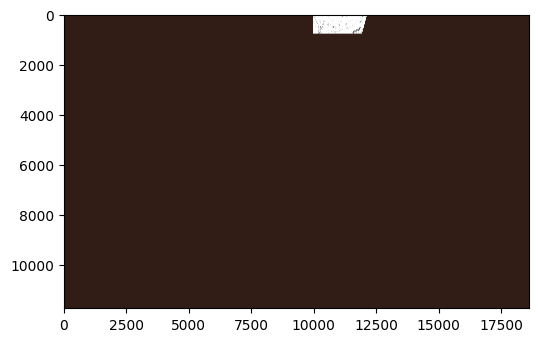

In [31]:
import matplotlib.pyplot as plt

mean = sentinel2_metainfo["mean"].iloc[:3].to_numpy()
std = sentinel2_metainfo["std"].iloc[:3].to_numpy()

scale = lambda x: ((x - mean) / std + 1) / 2

plt.figure(figsize=(6, 6))
plt.imshow(scale(array[0, :3].transpose(1, 2, 0)))
plt.show()

# plt.figure(figsize=(6, 6))
# plt.imshow(scale(array[-4, :3].transpose(1, 2, 0)))
# plt.show()

In [34]:
from pathlib import Path
from typing import Union

import rioxarray
import rasterio


def save_stack(stack: xr.DataArray, save_path: Union[str, Path]):
    if "eo:cloud_cover" in stack.coords:
        # Step 1: Find the time index with the least cloud coverage
        best_time_index = stack["eo:cloud_cover"].argmin().item()

        # Step 2: Select the best time slice
        selected_stack = stack.sel(time=stack.time[best_time_index])
    else:
        selected_stack = stack.sel(time=stack.time[0])

    # Step 3: Extract the acquisition date
    acquisition_date = pd.to_datetime(selected_stack.time.item()).strftime(
        "%Y-%m-%d %H:%M:%S"
    )

    # Step 4: Ensure CRS is set correctly
    selected_stack.rio.write_crs(stack.crs, inplace=True)

    # Step 5: Save as GeoTIFF with metadata
    metadata = {"DATE": acquisition_date}

    with rasterio.Env():  # Ensure the metadata is written
        selected_stack.rio.to_raster(
            Path(save_path).as_posix(),
            dtype="float32",
            tags=metadata,  # Embed acquisition date in metadata
        )

In [36]:
save_stack(stack, save_path="../data/stack.tif")

Image shape: (11739, 18593)


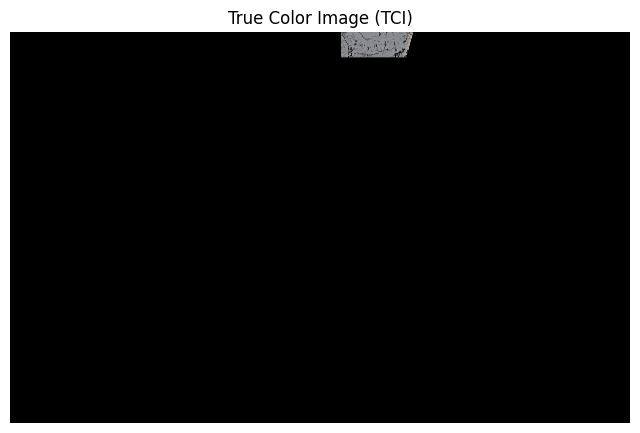

In [37]:
tiff_path = "../data/stack.tif"

with rasterio.open(tiff_path) as dataset:
    red = dataset.read(1)
    green = dataset.read(2)
    blue = dataset.read(3)
    nir = dataset.read(4)
    nir08 = dataset.read(5)
    swir = dataset.read(6)
    scl = dataset.read(7)

# Stack bands together into an RGB image
rgb_image = np.dstack((red, green, blue))

# Normalize for display
rgb_image = rgb_image.astype(np.float32)
rgb_image = (rgb_image - rgb_image.min()) / (rgb_image.max() - rgb_image.min())

print(f"Image shape: {rgb_image.shape[:2]}")

# Show image
plt.figure(figsize=(8, 8))
plt.imshow(rgb_image)
plt.axis("off")
plt.title("True Color Image (TCI)")
plt.show()

# By date

In [7]:
set(
    geometry_json["features"][i]["geometry"]["type"]
    for i in range(len(geometry_json["features"]))
)

{'MultiPolygon', 'Polygon'}

In [8]:
import geopandas as gpd
from shapely.geometry import Polygon, MultiPolygon

# Convert JSON to GeoDataFrame
json_gdf = gpd.GeoDataFrame(
    [
        {
            **d["properties"],  # Extract properties
            "geometry": (
                Polygon(
                    [tuple(point[:2]) for point in d["geometry"]["coordinates"][0]]
                    + [
                        tuple(d["geometry"]["coordinates"][0][0])
                    ]  # Ensure closed polygon
                )
                if d["geometry"]["type"] == "Polygon"
                else (
                    MultiPolygon(
                        [
                            Polygon([tuple(point) for point in poly] + [tuple(poly[0])])
                            for poly in d["geometry"]["coordinates"]
                            if len(poly)
                            >= 3  # Ensure each part of MultiPolygon has at least 3 points
                        ]
                    )
                    if d["geometry"]["type"] == "MultiPolygon"
                    else None
                )  # Skip invalid geometries
            ),
        }
        for d in geometry_json["features"]
    ],
    crs="EPSG:4326",
)

# # Drop invalid geometries (None values)
# json_gdf = json_gdf.dropna(subset=["geometry"])

In [9]:
geometries = dict()
for img_date in set(json_gdf["img_date"]):
    geometries[img_date] = shapely.ops.unary_union(
        json_gdf[json_gdf["img_date"] == img_date]["geometry"].to_list()
    ).convex_hull

In [10]:
from datetime import datetime, timedelta

In [15]:
date = "2018-08-30"

In [16]:
sample = {
    "geometry": geometries[date],
    "start_date": (datetime.strptime(date, "%Y-%m-%d") - timedelta(days=3)).strftime(
        "%Y-%m-%d"
    ),
    "end_date": (datetime.strptime(date, "%Y-%m-%d") + timedelta(days=3)).strftime(
        "%Y-%m-%d"
    ),
}

In [17]:
sample

{'geometry': <shapely.geometry.polygon.Polygon at 0x14797a310>,
 'start_date': '2018-08-27',
 'end_date': '2018-09-02'}

In [18]:
geometries.keys()

dict_keys(['2018-09-19', '2019-07-06', '2016-05-22', '2016-05-09', '2019-08-10', '2019-02-12', '2019-08-15', '2016-04-12', '2016-08-30', '2019-08-25', '2016-01-03', '2016-06-18', '2019-08-05', '2016-02-12', '2018-08-30', '2019-03-03', '2019-09-09', '2019-08-30', '2016-01-30', '2019-07-01', '2016-04-09', '2016-10-02', '2019-08-20', '2019-07-26', '2019-07-31', '2019-07-21', '2019-05-22', '2019-04-27', '2016-11-21', '2016-12-05', '2016-08-20', '2016-03-30', '2016-05-02', '2019-10-26', '2019-06-06', '2016-07-31', '2016-10-26', '2019-09-04', '2016-06-21'])

In [19]:
stack = prepare_datacube(sample, max_items=1, cloud_cover_cover_max=100, buffer_m=250)

collection: sentinel-2-l2a


/Users/yarem/Quantum/deforestation/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(


1


In [20]:
stack

<xarray.DataArray 'stackstac-89146752ab5cb863951d990f7646fb4d' (time: 1,
                                                                band: 7,
                                                                y: 8911, x: 9005)> Size: 2GB
dask.array<fetch_raster_window, shape=(1, 7, 8911, 9005), dtype=float32, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/14)
  * time                 (time) datetime64[ns] 8B 2018-09-02T08:56:13.880000
    id                   (time) <U24 96B 'S2A_36UXA_20180902_1_L2A'
  * band                 (band) <U6 168B 'blue' 'green' 'red' ... 'swir16' 'scl'
  * x                    (x) float64 72kB 6.185e+05 6.185e+05 ... 7.085e+05
  * y                    (y) float64 71kB 5.592e+06 5.592e+06 ... 5.503e+06
    eo:cloud_cover       float64 8B 69.85
    ...                   ...
    title                (band) <U30 840B 'Blue (band 2) - 10m' ... 'Scene cl...
    raster:bands         (band) object 56B {'offset': -0.1, 'data_type': 'uin...
    common_name          (band) object 56B 'blue' 'green' ... 'swir16' None
    center_wavelength    (band) object 56B 0.49 0.56 0.665 0.842 0.865 1.61 None
    full_width_half_max  (band) object 56B 0.098 0.045 0.038 ... 0.143 None
    epsg                 int64 8B 32636
Attributes:
    spec:        RasterSpec(epsg=32636, bounds=(618486.6661597841, 5502787.50...
    crs:         epsg:32636
    transform:   | 10.00, 0.00, 618486.67|\n| 0.00,-10.00, 5591897.36|\n| 0.0...
    resolution:  10

In [87]:
samples = [
    {
        "geometry": geometries[date],
        "start_date": (
            datetime.strptime(date, "%Y-%m-%d") - timedelta(days=3)
        ).strftime("%Y-%m-%d"),
        "end_date": (datetime.strptime(date, "%Y-%m-%d") + timedelta(days=3)).strftime(
            "%Y-%m-%d"
        ),
    }
    for date in geometries.keys()
]
samples

[{'geometry': <shapely.geometry.polygon.Polygon at 0x155882a60>,
  'start_date': '2016-06-18',
  'end_date': '2016-06-24'},
 {'geometry': <shapely.geometry.polygon.Polygon at 0x153f57b80>,
  'start_date': '2019-07-28',
  'end_date': '2019-08-03'},
 {'geometry': <shapely.geometry.polygon.Polygon at 0x155f6c130>,
  'start_date': '2019-08-17',
  'end_date': '2019-08-23'},
 {'geometry': <shapely.geometry.polygon.Polygon at 0x155862190>,
  'start_date': '2016-04-29',
  'end_date': '2016-05-05'},
 {'geometry': <shapely.geometry.polygon.Polygon at 0x155f6c370>,
  'start_date': '2019-09-06',
  'end_date': '2019-09-12'},
 {'geometry': <shapely.geometry.polygon.Polygon at 0x155926e20>,
  'start_date': '2016-07-28',
  'end_date': '2016-08-03'},
 {'geometry': <shapely.geometry.polygon.Polygon at 0x1559a9e20>,
  'start_date': '2016-01-27',
  'end_date': '2016-02-02'},
 {'geometry': <shapely.geometry.polygon.Polygon at 0x1558827f0>,
  'start_date': '2016-04-06',
  'end_date': '2016-04-12'},
 {'geome

In [117]:
stack = prepare_datacube(
    samples[1], max_items=1, cloud_cover_cover_max=100, buffer_m=250
)
stack

/Users/yarem/Quantum/deforestation/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(


<xarray.DataArray 'stackstac-077fd937a21c21c1621bd49a250bfd9f' (time: 0,
                                                                band: 0,
                                                                y: 2415, x: 332)> Size: 0B
dask.array<fetch_raster_window, shape=(0, 0, 2415, 332), dtype=float32, chunksize=(0, 0, 1024, 332), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 0B 
    id       (time) float64 0B 
  * band     (band) float64 0B 
  * x        (x) float64 3kB 3.365e+05 3.365e+05 ... 3.398e+05 3.398e+05
  * y        (y) float64 19kB 5.557e+06 5.557e+06 ... 5.533e+06 5.533e+06
    epsg     int64 8B 32636
Attributes:
    spec:        RasterSpec(epsg=32636, bounds=(336491.79011033796, 5533149.0...
    crs:         epsg:32636
    transform:   | 10.00, 0.00, 336491.79|\n| 0.00,-10.00, 5557303.20|\n| 0.0...
    resolution:  10

In [91]:
print(sample)

{'geometry': <shapely.geometry.polygon.Polygon object at 0x15611eb20>, 'start_date': '2018-08-27', 'end_date': '2018-09-02'}


In [116]:
print(samples[17])

{'geometry': <shapely.geometry.polygon.Polygon object at 0x155f6c3a0>, 'start_date': '2016-11-18', 'end_date': '2016-11-24'}


In [75]:
stacks = [
    prepare_datacube(sample, max_items=1, cloud_cover_cover_max=100, buffer_m=250)
    for sample in samples
]

/Users/yarem/Quantum/deforestation/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
/Users/yarem/Quantum/deforestation/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
/Users/yarem/Quantum/deforestation/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
/Users/yarem/Quantum/deforestation/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
/Users/yarem/Quantum/deforestation/.venv/lib/python3.9/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
/Users/yarem/Qu

In [76]:
len(stacks)

39

In [77]:
stacks = [stack for stack in stacks if stack is not None]

In [78]:
len(stacks)

21

In [79]:
stacks[18]

<xarray.DataArray 'stackstac-37eb2b44b89b1ce7382381f497647692' (time: 0,
                                                                band: 0,
                                                                y: 6563, x: 8340)> Size: 0B
dask.array<fetch_raster_window, shape=(0, 0, 6563, 8340), dtype=float32, chunksize=(0, 0, 1024, 1024), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 0B 
    id       (time) float64 0B 
  * band     (band) float64 0B 
  * x        (x) float64 67kB 2.692e+05 2.692e+05 ... 3.526e+05 3.526e+05
  * y        (y) float64 53kB 5.568e+06 5.568e+06 ... 5.503e+06 5.503e+06
    epsg     int64 8B 32636
Attributes:
    spec:        RasterSpec(epsg=32636, bounds=(269213.2102191441, 5502805.68...
    crs:         epsg:32636
    transform:   | 10.00, 0.00, 269213.21|\n| 0.00,-10.00, 5568435.79|\n| 0.0...
    resolution:  10